In [2]:
#Used to Mount the Drive Directory where our Data is saved
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Nedded imports
import numpy as np
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
#Get data from CSV files
def load_data_train(dim1,dim2):
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/X_train.csv") as f:
        X = []
        for val in f.readlines():
            val = val.replace("\n","")
            val = val.split(',')
            X.append([float(x) for x in val])
        X_train = np.array(X)
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/y_train.csv") as f2:
        Y = []
        for val in f2.readlines():
            val = val.replace("\n","")
            Y.append(float(val))
        y_train = np.array(Y)
    return (X_train, y_train)
def load_data_test(dim1,dim2):
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/X_test.csv") as f:
        X = []
        for val in f.readlines():
            val = val.replace("\n","")
            val = val.split(',')
            X.append([float(x) for x in val])
        X_test = np.array(X)
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/y_test.csv") as f2:
        Y = []
        for val in f2.readlines():
            val = val.replace("\n","")
            Y.append(float(val))
        y_test = np.array(Y)
    return (X_test, y_test)
def load_data_val(dim1,dim2):
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/X_val.csv") as f:
        X = []
        for val in f.readlines():
            val = val.replace("\n","")
            val = val.split(',')
            X.append([float(x) for x in val])
        X_val = np.array(X)
    with open("/content/drive/MyDrive/ML - Trabajo/"+str(dim1)+"x"+str(dim2) +"-RGB/y_val.csv") as f2:
        Y = []
        for val in f2.readlines():
            val = val.replace("\n","")
            Y.append(float(val))
        y_val = np.array(Y)
    return (X_val, y_val)


In [ ]:
#Get data from Image files (Takes a lot of time to execute ~ hours) (Need to download and reference the path well)
def load_data():
    with open('/content/drive/MyDrive/HAM10000_metadata') as f:
        X = []
        Y = []
        header = next(f)
        for val in f.readlines():
            val = val.replace("\n","")
            val = val.split(',')

            image = Image.open(os.path.join("/content/drive/MyDrive/Projecto", val[1]+".jpg"), "r").resize((200,150)).convert('L')
            data = np.asarray(image) /255
            X.append(data)
            Y.append(1 if val[2] == 'mel' else 0)
        X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size = 0.1,random_state=42)
    return (X_train, y_train), (X_test, y_test)
#Remove the """ to run the code if you want to exract the data directly for the image
    """
(X_train, y_train), (X_test, y_test) = load_data()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_validation = np.array(X_validation)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_validation = np.array(y_validation)

X_train_1 = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_validation_1 = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2])
  """

In [5]:
#Dimensions used
dim1 = 50
dim2 = 37
#Extract the data from the CSV files
(X_train, y_train) = load_data_train(dim1,dim2)

In [6]:
#Extract the data from the CSV files
(X_test, y_test) = load_data_test(dim1,dim2)
(X_val, y_val) = load_data_val(dim1,dim2)

In [7]:
#Merge the data in order to execute the SMOTE Algorithm
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis =0)
del X_val, y_val

Counter({0.0: 8010, 1.0: 1003})


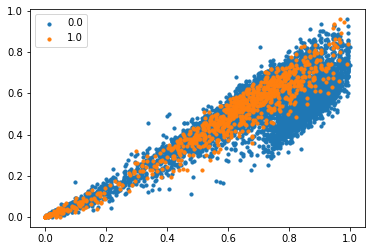

In [8]:
#Print the number of imbalanced data for each class (0-> No mel, 1-> Mel)
counter = Counter(y_train)
print(counter)

#Scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_train == label)[0]
	pyplot.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label), s= 10)
pyplot.legend()
pyplot.show()	

In [9]:
#Execute the Smote algorithm that generates synthetic samples of the minority class until this class has 80% of the number of samples that the minority class has
oversample = SMOTE(sampling_strategy=0.8, random_state=1234, k_neighbors=10, n_jobs= 2)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

Counter({0.0: 8010, 1.0: 6408})


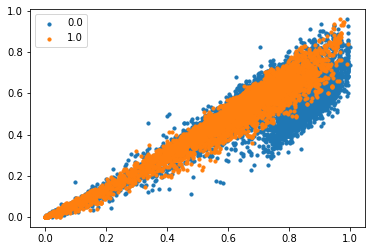

In [10]:
#Print the number of balanced data for each class (0-> No mel, 1-> Mel)
counter = Counter(y_train_smote)
print(counter)

#Scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_train_smote == label)[0]
	pyplot.scatter(X_train_smote[row_ix, 0], X_train_smote[row_ix, 1], label=str(label), s=10)
pyplot.legend()
pyplot.show()

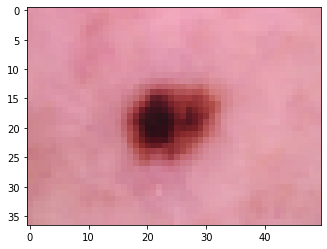

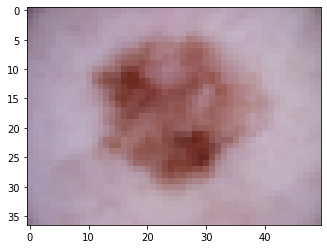

In [11]:
#Plot the images to see a image from the dataset and a synthetic image generated from SMOTE
pyplot.figure()
pyplot.imshow((X_train.reshape(X_train.shape[0],dim2,dim1,3)[0]), vmin=0, vmax=255)
pyplot.show()
pyplot.figure()
pyplot.imshow((X_train_smote.reshape(X_train_smote.shape[0],dim2,dim1,3)[13729]), vmin=0, vmax=255)
pyplot.show()

In [12]:
#Reshape the data as Images to feed the CNN
inputs = X_train_smote.reshape(X_train_smote.shape[0], dim1, dim2, 3)
#Encode labels into categorical encoding in order to feed the network
targets = tf.keras.utils.to_categorical(y_train_smote)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
205/205 [==============================] - 19s 31ms/step - loss: 0.5892 - categorical_accuracy: 0.6336 - val_loss: 0.5750 - val_categorical_accuracy: 0.6812
Epoch 2/50
205/205 [==============================] - 6s 29ms/step - loss: 0.5549 - categorical_accuracy: 0.6681 - val_loss: 0.5515 - val_categorical_accuracy: 0.6911
Epoch 3/50
205/205 [==============================] - 6s 29ms/step - loss: 0.5447 - categorical_accuracy: 0.6773 - val_loss: 0.5308 - val_categorical_accuracy: 0.7040
Epoch 4/50
205/205 [==============================] - 6s 29ms/step - loss: 0.5446 - categorical_accuracy: 0.6783 - val_loss: 0.5254 - val_categorical_accuracy: 0.7094
Epoch 5/50
205/205 [==============================] - 6s 29ms/step - loss: 0.5413 - categorical_accuracy: 0.6734 - val_loss: 0.5475 - val_categorical_accuracy: 0.6979
Epoch 6/50
205/205 [==============================] - 6s 29ms/step 

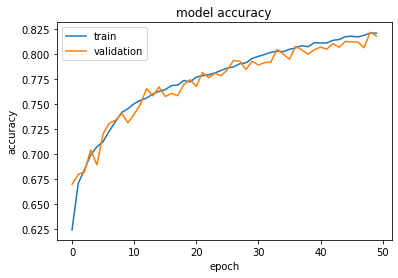

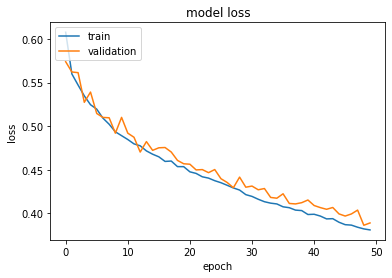

[[659 233]
 [ 25  85]]
Accuracy for class no mel: 0.7387892376681614
Accuracy for class mel: 0.7727272727272727
[[679 213]
 [ 30  80]]
Accuracy for class no mel: 0.7612107623318386
Accuracy for class mel: 0.7272727272727273
[[650 242]
 [ 21  89]]
Accuracy for class no mel: 0.7286995515695067
Accuracy for class mel: 0.8090909090909091
[[699 193]
 [ 33  77]]
Accuracy for class no mel: 0.7836322869955157
Accuracy for class mel: 0.7
[[710 182]
 [ 31  79]]
Accuracy for class no mel: 0.7959641255605381
Accuracy for class mel: 0.7181818181818181
[[658 234]
 [ 25  85]]
Accuracy for class no mel: 0.7376681614349776
Accuracy for class mel: 0.7727272727272727
[[689 203]
 [ 27  83]]
Accuracy for class no mel: 0.7724215246636771
Accuracy for class mel: 0.7545454545454545
[[687 205]
 [ 29  81]]
Accuracy for class no mel: 0.7701793721973094
Accuracy for class mel: 0.7363636363636363
[[636 256]
 [ 28  82]]
Accuracy for class no mel: 0.7130044843049327
Accuracy for class mel: 0.7454545454545455
[[606 2

In [13]:
#Number of splits used in the Kfold
split_number=11
kfold = KFold(n_splits=split_number, shuffle=True)
fold = 1
model_list=list()
validation_loss=list()
validation_acc=list()
validation_valloss=list()
validation_valacc=list()
#Trains different models split_number times
for train, test in kfold.split(inputs, targets):
  #Model Creation
  model = Sequential()

  #Convolutional Layer
  model.add(Conv2D(128, (3,3), activation='relu', input_shape=(dim1, dim2, 3)))
  model.add(Dropout(0.25))
  #Pooling Layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Convolutional Layer
  model.add(Conv2D(64, (3,3), activation='relu', input_shape=(dim1, dim2, 3)))
  model.add(Dropout(0.25))
  #Pooling Layer
  model.add(MaxPooling2D(pool_size=(2,2)))

  #Flatten output for the Dense Layer
  model.add(Flatten())
  #Dense layer
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.8))
  #Output layer
  model.add(Dense(2, activation='softmax'))
  #Model configuration (Loss & Optimizer)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['categorical_accuracy'])
  # Generate a print of number of fold
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold} ...')
  #Train parameters
  batch_size = 64
  epochs = 50
  #Fit training and validation data into the model & Train
  history = model.fit(inputs[train], targets[train], epochs=epochs, batch_size = batch_size, validation_data=(inputs[test], targets[test]), verbose=1)
  #Lists to save the accuracy and loss of each model
  validation_acc.append(history.history['categorical_accuracy'])
  validation_loss.append(history.history['loss'])
  validation_valacc.append(history.history['val_categorical_accuracy'])
  validation_valloss.append(history.history['val_loss'])
  #List to save each trained model
  model_list.append(model)
  fold=fold+1
#Plot the mean of the models accuracy
pyplot.plot(pd.DataFrame(validation_acc).mean())
pyplot.plot(pd.DataFrame(validation_valacc).mean())
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()
#This is to plot the loss graphs
pyplot.plot(pd.DataFrame(validation_loss).mean())
pyplot.plot(pd.DataFrame(validation_valloss).mean())
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()
#Reshape the data as Images to test the trained models
x_test = X_test.reshape(X_test.shape[0], dim1, dim2, 3)
#Encode labels into categorical encoding in order to test the models
y_test2 = tf.keras.utils.to_categorical(y_test)
#Testing of each model
for model in model_list:
  predictions = model.predict(x_test)
  predictions = (predictions > 0.5) 
  matriz=metrics.confusion_matrix(y_test,  predictions.argmax(axis=1))
  print(matriz)
  print("Accuracy for class no mel: " + str((matriz[0][0]/(matriz[0][0]+matriz[0][1]))))
  print("Accuracy for class mel: " + str((matriz[1][1]/(matriz[1][0]+matriz[1][1]))))


In [14]:
#Predicitions of each model for the given test dataset
predictions_list= list()
for model in model_list:
  predictions = model.predict(x_test)
  predictions = (predictions > 0.5) 
  predictions_list.append(predictions)
  matriz=metrics.confusion_matrix(y_test,  predictions.argmax(axis=1))
  #print(matriz)
  #print("Accuracy for class no mel: " + str((matriz[0][0]/(matriz[0][0]+matriz[0][1]))))
  #print("Accuracy for class mel: " + str((matriz[1][1]/(matriz[1][0]+matriz[1][1]))))

#Predicitions obtained by voting of all models
predictions = list()
for i in range(len(predictions_list[0])):
  result=0
  for j in range(split_number):
    result = result + predictions_list[j].argmax(axis=1)[i]
  if (result >= (int(split_number/2)+1)):
    predictions.append(1)
  else:
    predictions.append(0)
matriz=metrics.confusion_matrix(y_test,  predictions)
print(matriz)
print("Accuracy obtained by voting of all models for class no mel: " + str((matriz[0][0]/(matriz[0][0]+matriz[0][1]))))
print("Accuracy obtained by voting of all models for class mel: " + str((matriz[1][1]/(matriz[1][0]+matriz[1][1]))))

[[686 206]
 [ 24  86]]
Accuracy for class no mel: 0.7690582959641256
Accuracy for class mel: 0.7818181818181819
